In [1]:
#Upload Zip file and unzip it

#import zipfile as zf
#model_inputs = zf.ZipFile("model_inputs.zip", 'r')
#model_inputs.extractall('model_inputs')
#model_inputs.close()

#!pip install rasterio
#!pip install geopandas
#!pip install seaborn
#!pip install pandas
#!pip install rasterstats

#from rasterio.transform import from_origin
#from rasterstats import zonal_stats
#import seaborn as sns # similar to ggpot2 R library
#import matplotlib.pyplot as plt

In [2]:
import rasterio # similar to raster R library  
import geopandas as gpd #This includes fiona python library, and is similar to sp and sf R libraries
import pandas as pd

import numpy as np
from numpy import nan

from rasterio.plot import show

In [3]:
#geopandas built on top of fiona is used for reading and writing spacial data files 

#reading shp files using geopandas
mena_shp = gpd.read_file("model_inputs/model_inputs/MENA_countries_IWMI_final_buffer2.shp")	#read MENA_boundary shp file
mena_shp_buff = gpd.read_file("model_inputs/model_inputs/MENA_countries_IWMI_final_buffer2.shp")
mena_cnts = gpd.read_file("model_inputs/model_inputs/MENA_countries_IWMI_final2.shp")
#mena_shp.head()
#mena_shp.plot()

In [4]:
#reading input raster 
mena_zone_buff = rasterio.open("model_inputs/model_inputs/mena_zone_buff.tif")


mena_zone_buff_array = mena_zone_buff.read(1)  # Read the fist layer into a NumPy array 
mena_zone_buff_array[mena_zone_buff_array < 0] = np.nan 
mena_zone_buff_array[mena_zone_buff_array == 22] = np.nan

In [5]:
#terra and rgdal package in R overlaps with rasterio, gdal and geopandas python packages

mask = rasterio.open("model_inputs/model_inputs/mask_land_soutfall_river_new6.tif")
mena_zone = rasterio.open("model_inputs/model_inputs/mena_shp_rast_resamp.tif")
#coast_buff = rasterio.open("model_inputs/model_inputs/coastal_buff_10km_reclass.tif")
wbal = rasterio.open("model_inputs/model_inputs/wb_ltm_2015_resamp.tif") #precalculated file 
gwreach = rasterio.open("model_inputs/model_inputs/gw_reach_potential_2015_new_resamp.tif")

#There are 5 populations: ghspop, gpwpop, grump, lspop and wpop - change the below input for the required population accordingly 

ghspop = rasterio.open("model_inputs/model_inputs/MENA_GHSpop_pop_count_v1_2015_1km_resamp.tif")  #read ghspop data
cnt_list = mena_cnts['ADM0_NAME'] 
ce = rasterio.open("model_inputs/model_inputs/TEXMHT_M_sl1-6avg_250m_ll_MENA_resampled_ce.tif")  #conveyance_efficiencey_based on soil texture


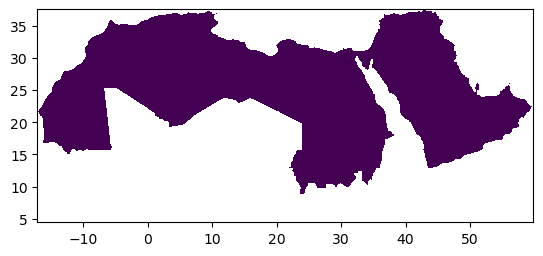

<Axes: >

In [6]:
####Visulaization of the relevant population data
data_ghspop = ghspop
show(data_ghspop)

In [7]:

ghspop_urclass = data_ghspop.read()  # Turns data_ghspop raster into an array

# Set values below and equal 1 to NaN
ghspop_urclass[ghspop_urclass <= 1] = np.nan

# Set values between 1 and 300 (including 300) to 1
ghspop_urclass[(ghspop_urclass > 1) & (ghspop_urclass <= 300)] = 1

# Set values between 300 and 1500 (including 1500) to 2
ghspop_urclass[(ghspop_urclass > 300) & (ghspop_urclass <= 1500)] = 2

# Set values above 1500 to 3
ghspop_urclass[ghspop_urclass > 1500] = 3

print("\nReclassified Data:")
print(ghspop_urclass)




Reclassified Data:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [8]:
#write the file
with rasterio.open('01_MENA_ghspop_urban_rural_areas.tif', 'w',
                  driver = data_ghspop.driver,
                  height = data_ghspop.height,
                  width = data_ghspop.width,
                  count = data_ghspop.count,
                  crs = data_ghspop.crs,
                  transform = data_ghspop.transform, 
                  dtype = ghspop_urclass.dtype
                   
                  ) as dst:
    dst.write(ghspop_urclass)


In [9]:
###Extract population counts for rural and urban classes  
####classifying class 3 as urban and class 1 & 2 as rural

rurpop = ghspop.read()
rurpop[rurpop  < 0] = np.nan  
rurpop[(rurpop > 300)] = 0 # Set elements greater than 300 to 0
#rurpop[ghspop_urclass > 1] = 0

with rasterio.open('02_MENA_ghspop_pop4rural_class_only.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rurpop.dtype 
                  ) as dst:
    dst.write(rurpop)


In [10]:
urbpop = ghspop.read()
urbpop[urbpop   < 0] = np.nan 
urbpop[(urbpop <= 300)] = 0 # Set elements less than or equal to 300 to 0
#urbpop[(ghspop_urclass < 2)] = 0

with rasterio.open('03_MENA_ghspop_pop4urban_class_only.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urbpop.dtype
                   
                  ) as dst:
    dst.write(urbpop)

In [11]:
###Codes to derive per capital MWW estimates for urban and rural classes
####Per capita rates for Urban should be twice that of rural areas
###Total per capita rates should match the rates obtained from Sagasta et al.. 

In [12]:

mena_zone_buff_flat = mena_zone_buff_array.flatten()
IDs = np.unique(mena_zone_buff_flat)  
IDs = IDs[~np.isnan(IDs)]
empty_1 = {'zone': [], 'sum': []}  

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply transf with rurpop
    sum_zone = transf * rurpop
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_1['zone'].append(int(id))
    empty_1['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
ruralpop = pd.DataFrame(empty_1)

# Display the resulting DataFrame
print(ruralpop)


    zone           sum
0      1  648519.29553
1      2 1670455.81814
2      3   42036.52646
3      4    5964.15196
4      5 1046984.29505
5      6  299960.33754
6      7  275237.66106
7      8   95041.86185
8      9  241640.93459
9     10  515771.79231
10    11 1211793.62696
11    12  250089.20931
12    13   90764.03101
13    14 1074747.70965
14    15  954087.66610
15    16  524067.58680
16    17  293118.52598
17    18  238955.52640
18    19  537848.78034
19    20 2483590.14631
20    21  121446.40934


In [13]:
empty_2 = {'zone': [], 'sum': []}  

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply transf with urbpop
    sum_zone = transf * urbpop
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_2['zone'].append(int(id))
    empty_2['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
urbanpop = pd.DataFrame(empty_2)

# Display the resulting DataFrame
print(urbanpop)


    zone           sum
0      1 2359388.31064
1      2 1922763.73141
2      3   59989.81064
3      4   25327.43890
4      5 2133187.52057
5      6  308761.26404
6      7  352563.78333
7      8  254761.18005
8      9  257022.51340
9     10   36408.11829
10    11 1842584.62283
11    12  109238.27017
12    13   89867.11880
13    14 1439407.09848
14    15  729186.14890
15    16  524901.26434
16    17  451426.15421
17    18  188165.67776
18    19 1532188.74545
19    20 5253977.72919
20    21  189365.22589


In [14]:
ghspop_values = ghspop.read()
ghspop_values[ghspop_values < 0] = np.nan

ghstotpop = {'zone': [], 'sum': []}

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)

    # Multiply transf with ghspop_values
    sum_zone = transf * ghspop_values

    # Sum of values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated sum for the current id to the dictionary
    ghstotpop['zone'].append(int(id))
    ghstotpop['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
ghstotal_pop = pd.DataFrame(ghstotpop)

# Display the resulting DataFrame
print(ghstotal_pop)



    zone           sum
0      1 3007907.60616
1      2 3593219.54956
2      3  102026.33710
3      4   31291.59086
4      5 3180171.81562
5      6  608721.60158
6      7  627801.44439
7      8  349803.04190
8      9  498663.44799
9     10  552179.91060
10    11 3054378.24980
11    12  359327.47949
12    13  180631.14982
13    14 2514154.80813
14    15 1683273.81499
15    16 1048968.85115
16    17  744544.68019
17    18  427121.20416
18    19 2070037.52579
19    20 7737567.87550
20    21  310811.63523


In [15]:
import pandas as pd

# Using the dataFrames named ruralpop, urbanpop, ghstotal_pop, and mena_cnts

# Extracting columns 'sum' and 'id' from each DataFrame
rural_pop = ruralpop['sum']*10
urban_pop = urbanpop['sum']*10
ghstot_pop  = ghstotal_pop['sum']*10

# Calculating total population
totpop = rural_pop + urban_pop

# Extracting columns 'MWW_new' and 'Tot_pop' from mena_cnts
mww = mena_cnts['MWW_new'] * 10**9
totalpop = mena_cnts['Tot_pop'] * 1000

# Handling NaN values in mww
mww = mww.fillna(0)

# Creating a DataFrame 'tot_pop'
tot_pop = pd.DataFrame({'totpop': totpop, 'rural_pop': rural_pop, 'urban_pop': urban_pop})

# Writing the DataFrame to a text file
tot_pop.to_csv('ghspop_total_rural_urban_pop.txt', sep='\t', index=False) #, fmt='%.10f'


In [16]:
# Calculate per capita MWW

pc_mww = mww / totpop # pc_mww has 21 elements

In [17]:
# Write per capita MWW to a text file
pc_mww.to_csv('MENA_ghspop_per_capita_mww.txt', header=False, index=False)

# Initialize empty vectors for pc_urban and pc_rural
pc_urban = np.empty(len(pc_mww))  
pc_rural = np.empty(len(pc_mww))

# Loop through each element in pc_mww
for i in range(len(pc_mww)): # has 21 elements
    pc_urb = pc_mww[i]
    urb_frac = 1.0

    while urb_frac <= 2.0:
        pc_rur = (mww[i] - (pc_urb * urban_pop[i])) / rural_pop[i]
        urb_frac = pc_urb / pc_rur
        pc_urb += 0.01

        if np.isnan(urb_frac):
            urb_frac = 2.1

    print(i)
    pc_urban[i] = pc_urb - 0.01
    pc_rural[i] = pc_rur

# Set the display format for floats
pd.options.display.float_format = '{:.12f}'.format

# Write pc_urban to a text file
np.savetxt('MENA_ghspop_per_capita_mww_urban.txt', pc_urban, fmt='%.12f')

# Write pc_rural to a text file
np.savetxt('MENA_ghspop_per_capita_mww_rural.txt', pc_rural, fmt='%.12f')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [18]:
#computing a raster with pc_urban, use mena_zone_buff_array and multipy pc_urban values for each country.

mena_pc_urb = np.copy(mena_zone_buff_array)

#The loop for i in range(1, 22): iterates over the values from 1 to 21.
for i in range(1, 22):
    mena_pc_urb[mena_zone_buff_array == i] = pc_urban[i - 1]

mena_pc_rur = np.copy(mena_zone_buff_array)
for i in range(1, 22):
    mena_pc_rur[mena_zone_buff_array == i] = pc_rural[i - 1]
    

In [19]:
#computing rural MWW

#rural = rasterio.open("MENA_ghspop_pop4rural_class_only.tif")
rural_mww = rurpop * mena_pc_rur * 10

with rasterio.open('004_MENA_ghspop_mww_rural.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_mww.dtype
                   
                  ) as dst:
    dst.write(rural_mww)


In [20]:
#computing rural MWW
urban_mww = urbpop * mena_pc_urb *10



with rasterio.open('005_MENA_ghspop_mww_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww.dtype
                   
                  ) as dst:
    dst.write(urban_mww)


In [21]:
ghspop_mww = urban_mww + rural_mww


with rasterio.open('006_MENA_ghspop_mww_total.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = ghspop_mww.dtype
                   
                  ) as dst:
    dst.write(ghspop_mww)


In [22]:
#extract rural mww, urban mww, and total mww

In [23]:
empty_3 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf with rural_mww
    sum_zone = transf * rural_mww
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_3['zone'].append(int(id))
    empty_3['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.0f}'.format

# Convert the dictionary to a DataFrame
rural_mww_cnt = pd.DataFrame(empty_3)

print(rural_mww_cnt)

# Write to text file with specified format
np.savetxt('001_MENA_ghspop_mww_rur_cnt.txt', rural_mww_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')


    zone        sum
0      1  164163980
1      2  726763555
2      3   40214561
3      4    2275011
4      5  214649114
5      6  171634082
6      7   47700471
7      8   48713624
8      9  147083866
9     10  420615375
10    11  175552433
11    12  122751545
12    13   67101925
13    14  434948525
14    15  466626333
15    16   79907152
16    17  183809101
17    18   61497563
18    19   43173468
19    20 1242569111
20    21   29126293


In [24]:
empty_4 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf with urban_mww
    sum_zone = transf * urban_mww
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_4['zone'].append(int(id))
    empty_4['sum'].append(float(sum_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.0f}'.format

# Convert the dictionary to a DataFrame
urban_mww_cnt = pd.DataFrame(empty_4)

print(urban_mww_cnt)
 
# Write to text file with specified format
np.savetxt('002_MENA_ghspop_mww_urb_cnt.txt', urban_mww_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone        sum
0      1 1195836016
1      2 1673236463
2      3  114785435
3      4   19334989
4      5  875350893
5      6  353365904
6      7  122299530
7      8  261286384
8      9  312916126
9     10   59384621
10    11  534447558
11    12  107248459
12    13  132898077
13    14 1165051417
14    15  713373670
15    16  160092843
16    17  566190901
17    18   96892440
18    19  246826528
19    20 5257431020
20    21   90873710


In [25]:
empty_5 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf with ghspop_mww
    sum_zone = transf * ghspop_mww
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_5['zone'].append(int(id))
    empty_5['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
ghspop_mww_cnt = pd.DataFrame(empty_5)

print(ghspop_mww_cnt)

# Write to text file with specified format
np.savetxt('003_MENA_ghspop_mww_tot_cnt.txt', ghspop_mww_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone        sum
0      1 1359999996
1      2 2400000019
2      3  154999996
3      4   21610000
4      5 1090000007
5      6  524999985
6      7  170000001
7      8  310000008
8      9  459999992
9     10  479999997
10    11  709999991
11    12  230000004
12    13  200000001
13    14 1599999943
14    15 1180000003
15    16  239999996
16    17  750000002
17    18  158390002
18    19  289999995
19    20 6500000131
20    21  120000003


In [26]:
#model gw recharge fraction image

mww_m3 = ghspop_mww
mww_mm = (mww_m3 / (833.33 * 833.33)) * 1000
wbal = rasterio.open("model_inputs/model_inputs/wb_ltm_2015_resamp.tif") #precalculated file copy this into the working directory
gwreach = rasterio.open("model_inputs/model_inputs/gw_reach_potential_2015_new_resamp.tif")

gwreach = gwreach.read()
gwreach[gwreach == np.min(gwreach)] = np.nan  # found using np.min(gwreach)
wbal_p = wbal.read()
#wbal_p[wbal_p < 0] <- 0 #converting all negative numbers to 0   
#compute gw recharge fraction
wbal_p[wbal_p == np.min(wbal_p)] = np.nan


In [27]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    theta = gwreach / (wbal_p + mww_mm)  
    
theta[theta > 1] = 1
#set higher theta for negative wb pixels/irrigated areas
theta[wbal_p < 0] = 0.15  # assuming that MWW will recharge at a higher rates in the irrigated regions

In [28]:
#set theta for urban areas to 0.01
theta[ghspop_values > 300] = 0.05 #set theta for urban clusters to 5%
theta[ghspop_values > 1500] = 0.10 #set theta for urban to 10% (see references in the manuscript)
theta[np.isnan(theta)] = 0.1
theta[np.isnan(ghspop_values)] = np.nan
theta[theta == 999] = 0.1

with rasterio.open('022_MENA_ghspop_groundwater_recharge_frac.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = theta.dtype
                   
                  ) as dst:
    dst.write(theta)


In [29]:
# Assuming mask is a NumPy array
##extract MWW river (rural)
riv_mask = mask.read()
riv_mask[riv_mask != 1] = np.nan

In [30]:
# Create a boolean mask where nan values are False and other values are True
bool_mask_1 = ~np.isnan(riv_mask)

# Apply the boolean mask to get the desired result
riv_mask_boolean = bool_mask_1.astype(bool)

# Display the original and boolean masked arrays
print("Original riv_mask:")
print(riv_mask)
print("\nBoolean Mask riv_mask_boolean:")
print(riv_mask_boolean)

Original riv_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask riv_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


In [31]:
# Create a new array with nan for False values in riv_mask
rural_mww_riv = np.where(riv_mask_boolean, rural_mww, np.nan)

# Display the result
print("Original rural_mww:", rural_mww)
print("rural_mww_riv:", rural_mww_riv)


Original rural_mww: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
rural_mww_riv: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [32]:
with rasterio.open('004_MENA_ghspop_mww_rur_river.tif', 'w',
                  driver = mask.driver,
                  height = mask.height,
                  width = mask.width,
                  count = mask.count,
                  crs = mask.crs,
                  transform = mask.transform, 
                  dtype = rural_mww_riv.dtype
                   
                  ) as dst:
    dst.write(rural_mww_riv)
    
    
empty_6 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with rural_mww_riv
    sum_zone = transf * rural_mww_riv
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_6['zone'].append(int(id))
    empty_6['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
rural_mww_riv_cnt = pd.DataFrame(empty_6)

print(rural_mww_riv_cnt)

# Write to text file with specified format
np.savetxt('004_MENA_ghspop_mww_rur_river_cnt.txt', rural_mww_riv_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone        sum
0      1  101630907
1      2  200408775
2      3          0
3      4          0
4      5  122308228
5      6   15203073
6      7   12455540
7      8    7862241
8      9          0
9     10   34723454
10    11   44437774
11    12    9707798
12    13          0
13    14  131662832
14    15  164358230
15    16   11959327
16    17    1470254
17    18    7233325
18    19    8337502
19    20 1071119424
20    21    5572794


In [33]:
##extract Soutfall MWW (rural)
sout_mask = mask.read()
sout_mask[sout_mask != 2] = np.nan

# Create a boolean mask where nan values are False and other values are True
bool_mask_2 = ~np.isnan(sout_mask)

# Apply the boolean mask to get the desired result
sout_mask_boolean = bool_mask_2.astype(bool)

# Display the original and boolean masked arrays
print("Original sout_mask:")
print(sout_mask)
print("\nBoolean Mask sout_mask_boolean:")
print(sout_mask_boolean)

# Create a new array with nan for False values in sout_mask
rural_mww_soutfall = np.where(sout_mask_boolean, rural_mww, np.nan)

# Display the result
print("rural_mww_soutfall:", rural_mww_soutfall)


Original sout_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask sout_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
rural_mww_soutfall: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [34]:
with rasterio.open('005_MENA_ghspop_mww_rur_seaoutfall.tif', 'w',
                  driver = mask.driver,
                  height = mask.height,
                  width = mask.width,
                  count = mask.count,
                  crs = mask.crs,
                  transform = mask.transform, 
                  dtype = rural_mww_soutfall.dtype
                   
                  ) as dst:
    dst.write(rural_mww_soutfall)
    
    
empty_7 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with rural_mww_soutfall
    sum_zone = transf * rural_mww_soutfall
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_7['zone'].append(int(id))
    empty_7['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
rural_mww_sout_cnt = pd.DataFrame(empty_7)

# Convert the column to integers
rural_mww_sout_cnt['zone'] = rural_mww_sout_cnt['zone'].astype(int)

print(rural_mww_sout_cnt)

np.savetxt('005_MENA_ghspop_mww_rur_soutfall_cnt.txt', rural_mww_sout_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone       sum
0      1   2992023
1      2 136188329
2      3  29692597
3      4   2275011
4      5  18319086
5      6  85987111
6      7   1271281
7      8  39263482
8      9  68745175
9     10 273214703
10    11  37526285
11    12  68964468
12    13  52853725
13    14  99966578
14    15  25884266
15    16  39496892
16    17 107773658
17    18    149618
18    19   3635266
19    20  73683880
20    21   6069844


In [35]:
##extract MWW land (rural)
oland_mask = mask.read()
oland_mask[oland_mask != 3] = np.nan

# Create a boolean mask where nan values are False and other values are True
bool_mask_3 = ~np.isnan(oland_mask)

# Apply the boolean mask to get the desired result
oland_mask_boolean = bool_mask_3.astype(bool)

# Display the original and boolean masked arrays
print("Original oland_mask:")
print(oland_mask)
print("\nBoolean Mask oland_mask_boolean:")
print(oland_mask_boolean)

# Create a new array with nan for False values in sout_mask
rural_mww_oland  = np.where(oland_mask_boolean, rural_mww, np.nan)

# Display the result
print("rural_mww_oland :", rural_mww_oland)


Original oland_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask oland_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
rural_mww_oland : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [36]:
with rasterio.open('006_MENA_ghspop_mww_rur_oland.tif', 'w',
                  driver = mask.driver,
                  height = mask.height,
                  width = mask.width,
                  count = mask.count,
                  crs = mask.crs,
                  transform = mask.transform, 
                  dtype = rural_mww_oland.dtype
                   
                  ) as dst:
    dst.write(rural_mww_oland)
    
    
empty_8 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with rural_mww_oland
    sum_zone = transf * rural_mww_oland
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_8['zone'].append(int(id))
    empty_8['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
rural_mww_oland_cnt = pd.DataFrame(empty_8)

# Convert the column to integers
rural_mww_oland_cnt['zone'] = rural_mww_oland_cnt['zone'].astype(int)

print(rural_mww_oland_cnt)

np.savetxt('006_MENA_ghspop_mww_rur_overland_cnt.txt', rural_mww_oland_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')



    zone       sum
0      1  59541050
1      2 390166452
2      3  10521964
3      4         0
4      5  74021800
5      6  70443898
6      7  33973651
7      8   1587901
8      9  78338691
9     10 112677218
10    11  93588373
11    12  44079279
12    13  14248200
13    14 203319115
14    15 276383837
15    16  28450933
16    17  74565189
17    18  54114620
18    19  31200699
19    20  97765807
20    21  17483655


In [37]:
##extract MWW river (urban)

# Create a boolean mask where nan values are False and other values are True
bool_mask_4 = ~np.isnan(riv_mask)

# Apply the boolean mask to get the desired result
riv_mask_boolean = bool_mask_4.astype(bool)

# Display the original and boolean masked arrays
print("Original riv_mask:")
print(riv_mask)
print("\nBoolean Mask riv_mask_boolean:")
print(riv_mask_boolean)

# Create a new array with nan for False values in riv_mask
urban_mww_riv  = np.where(riv_mask_boolean, urban_mww, np.nan)

# Display the result
print("urban_mww_riv :", urban_mww_riv)



Original riv_mask:
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]

Boolean Mask riv_mask_boolean:
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
urban_mww_riv : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [38]:
with rasterio.open('007_MENA_ghspop_mww_urb_river.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_riv.dtype
                   
                  ) as dst:
    dst.write(urban_mww_riv)
    
    
empty_9 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with urban_mww_riv
    sum_zone = transf * urban_mww_riv
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_9['zone'].append(int(id))
    empty_9['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
urban_mww_riv_cnt = pd.DataFrame(empty_9)

# Convert the column to integers
urban_mww_riv_cnt['zone'] = urban_mww_riv_cnt['zone'].astype(int)

print(urban_mww_riv_cnt)

np.savetxt('007_MENA_ghspop_mww_urb_river_cnt.txt', urban_mww_riv_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')


    zone        sum
0      1  658989212
1      2  425923787
2      3          0
3      4          0
4      5  510890901
5      6    6418112
6      7   12240226
7      8    4578541
8      9          0
9     10   11486568
10    11  101584177
11    12   10619681
12    13          0
13    14  181969234
14    15  177490264
15    16   18902321
16    17          0
17    18    1430367
18    19   14542605
19    20 4918365009
20    21   15236989


In [39]:
##extract Soutfall MWW (urban)

# Create a new array with nan for False values in riv_mask
urban_mww_soutfall  = np.where(sout_mask_boolean, urban_mww, np.nan)

# Display the result
print("urban_mww_soutfall :", urban_mww_soutfall)

urban_mww_soutfall : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [40]:
with rasterio.open('008_MENA_ghspop_mww_urb_seaoutfall.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_soutfall.dtype
                   
                  ) as dst:
    dst.write(urban_mww_soutfall)
    
    
empty_10 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with urban_mww_soutfall
    sum_zone = transf * urban_mww_soutfall
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_10['zone'].append(int(id))
    empty_10['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
urban_mww_sout_cnt = pd.DataFrame(empty_10)

# Convert the column to integers
urban_mww_sout_cnt['zone'] = urban_mww_sout_cnt['zone'].astype(int)

print(urban_mww_sout_cnt)

np.savetxt('008_MENA_ghspop_mww_urb_soutfall_cnt.txt', urban_mww_sout_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone       sum
0      1  25651137
1      2 467542742
2      3  91757613
3      4  19334989
4      5  92192083
5      6 287177850
6      7   2042891
7      8 256707842
8      9 291637649
9     10  17603273
10    11 231529822
11    12  80920107
12    13  99533309
13    14 285213363
14    15  31495743
15    16  73269398
16    17 484876051
17    18         0
18    19  32304568
19    20 170797912
20    21  42456451


In [41]:
##extract MWW land (urban)

# Create a new array with nan for False values in riv_mask
urban_mww_oland  = np.where(oland_mask_boolean, urban_mww, np.nan)

# Display the result
print("urban_mww_oland :", urban_mww_oland)

urban_mww_oland : [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [42]:
with rasterio.open('009_MENA_ghspop_mww_urb_oland.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_oland.dtype
                   
                  ) as dst:
    dst.write(urban_mww_oland)
    
    
empty_11 = {'zone': [], 'sum': []} 

for id in IDs:
    transf = np.where(mena_zone_buff_array == id, 1, 0)
    
    # Multiply the transf  with urban_mww_oland
    sum_zone = transf * urban_mww_oland
    
    # Sum the values along the flattened array, ignoring NaN values
    sum_zone = np.nansum(sum_zone)
    
    # Append the calculated sum for the current id to the dictionary
    empty_11['zone'].append(int(id))
    empty_11['sum'].append(float(sum_zone))

# Convert the dictionary to a DataFrame
urban_mww_oland_cnt  = pd.DataFrame(empty_11)

# Convert the column to integers
urban_mww_oland_cnt['zone'] = urban_mww_oland_cnt['zone'].astype(int)

print(urban_mww_oland_cnt)

np.savetxt('009_MENA_ghspop_mww_urb_overland_cnt.txt', urban_mww_oland_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

    zone       sum
0      1 511195667
1      2 779769935
2      3  23027822
3      4         0
4      5 272267909
5      6  59769942
6      7 108016413
7      8         0
8      9  21278477
9     10  30294780
10    11 201333559
11    12  15708671
12    13  33364768
13    14 697868821
14    15 504387663
15    16  67921125
16    17  81314851
17    18  95462073
18    19 199979354
19    20 168268100
20    21  33180269


In [43]:
####codes to generate table 3

In [44]:
file_path = "model_inputs/model_inputs/direct_reuse_new2.txt"

# Read the text file into a DataFrame
dir_reuse = pd.read_csv(file_path, sep='\t')

# Display the DataFrame
print(dir_reuse)

    No      Country  river  coast  land  total
0    1        Sudan     29      0     0     29
1    2      Algeria     56      8    36    100
2    3      Bahrain      0     30     0     30
3    4        Gaza       0      0     0      0
4    5         Iraq      0      0     0      0
5    6       Israel      0      0     0      0
6    7       Jordan      6      0    65     71
7    8       Kuwait     10    259     0    268
8    9      Lebanon      0      0     2      2
9   10       Libyan      0     40     0     40
10  11      Morocco      3     26    47     76
11  12         Oman      0     64     5     70
12  13        Qatar      0    136     0    136
13  14  SaudiArabia      4    200   188    392
14  15        Syria      0      0     0      0
15  16      Tunisia      6     27     1     34
16  17          UAE      1    406   116    540
17  18     WestBank      0      0     6      6
18  19        Yemen      0     12    24     36
19  20        Egypt    111     44   134    289
20  21   Maur

In [45]:
theta_array = theta.astype(float)  # Convert to float data type

empty_12 = {'zone': [], 'mean': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with theta_array
    sum_zone = transf * theta_array
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Number of values corresponding to the current ID
    num_values = np.sum(transf)
    
    # Calculate the mean by dividing the sum by the number of values
    mean_zone = sum_zone / num_values if num_values != 0 else np.nan
    
    # Append the calculated mean for the current id to the dictionary
    empty_12['zone'].append(int(id))
    empty_12['mean'].append(float(mean_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
theta_cnt = pd.DataFrame(empty_12)

# Convert the column to integers
theta_cnt['zone'] = theta_cnt['zone'].astype(int)

print(theta_cnt)


    zone    mean
0      1 0.07241
1      2 0.07002
2      3 0.03686
3      4 0.02808
4      5 0.04964
5      6 0.05796
6      7 0.03689
7      8 0.04319
8      9 0.13904
9     10 0.02743
10    11 0.17815
11    12 0.06576
12    13 0.01706
13    14 0.02750
14    15 0.06095
15    16 0.08230
16    17 0.02440
17    18 0.13998
18    19 0.04288
19    20 0.02607
20    21 0.05256


In [46]:
ce_array = ce.read()
ce_array = ce_array.astype(float)  # Convert to float data type

ce_array[ce_array < 0] = np.nan  # Assign NaN to where it is required


empty_13 = {'zone': [], 'mean': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with ce_array
    sum_zone = transf * ce_array
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Number of values corresponding to the current ID
    num_values = np.sum(transf)
    
    # Calculate the mean by dividing the sum by the number of values
    mean_zone = sum_zone / num_values if num_values != 0 else np.nan
    
    # Append the calculated mean for the current id to the dictionary
    empty_13['zone'].append(int(id))
    empty_13['mean'].append(float(mean_zone))

# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.5f}'.format

# Convert the dictionary to a DataFrame
ce_cnt = pd.DataFrame(empty_13)

# Convert the column to integers
ce_cnt['zone'] = ce_cnt['zone'].astype(int)

print(ce_cnt)

    zone     mean
0      1 64.92128
1      2 63.38286
2      3 23.34352
3      4 21.45741
4      5 65.97221
5      6 65.34341
6      7 68.09275
7      8 59.86747
8      9 62.89358
9     10 61.83572
10    11 66.85064
11    12 61.21406
12    13 52.34362
13    14 62.84147
14    15 67.39905
15    16 64.45756
16    17 56.87946
17    18 67.32263
18    19 61.95166
19    20 61.40308
20    21 61.85848


In [47]:
ce_cnt_val = ce_cnt['mean']	
ce_cnt_val = ce_cnt_val.copy()  # Create a copy of the DataFrame
ce_cnt_val[ce_cnt_val > 100] = 100

In [48]:
#########################################################################################################################################################

In [49]:
mww_riv_cnt = rural_mww_riv_cnt['sum'] + urban_mww_riv_cnt['sum']
mww_riv_dru = dir_reuse['river'] * 10**6

In [50]:
mww_riv_gwr = (mww_riv_cnt - mww_riv_dru) * theta_cnt['mean']  # groundwater recharge (indirect reuse part)
mww_riv_rir = (mww_riv_cnt - mww_riv_dru - mww_riv_gwr) * (ce_cnt_val/100)  #river indirect reuse		
mww_riv_pir = mww_riv_gwr + mww_riv_rir	#total productive use (indirect)
mww_riv_upu = mww_riv_cnt - mww_riv_dru - mww_riv_pir 	#unproductive use
mww_riv_pu = mww_riv_pir + mww_riv_dru	#total productive use (direct + indirect)

In [51]:
mww_sea_cnt = rural_mww_sout_cnt['sum'] + urban_mww_sout_cnt['sum']
mww_sea_dru = dir_reuse['coast'] * 10**6
mww_sea_pir = (mww_sea_cnt - mww_sea_dru) * theta_cnt['mean']
mww_sea_upu = mww_sea_cnt - mww_sea_dru - mww_sea_pir
mww_sea_pu = mww_sea_pir + mww_sea_dru

mww_land_cnt = rural_mww_oland_cnt['sum'] + urban_mww_oland_cnt['sum']
mww_land_dru = dir_reuse['land'] * 10**6
mww_land_pir = (mww_land_cnt - mww_land_dru) * theta_cnt['mean']
mww_land_upu = mww_land_cnt - mww_land_dru - mww_land_pir
mww_land_pu = mww_land_pir + mww_land_dru

In [52]:
cnt_list = mena_cnts['ADM0_NAME']

# Create a DataFrame
data_out_riv = pd.DataFrame({
    'cnt_list': cnt_list,
    'mww_riv_dru': mww_riv_dru,
    'mww_sea_dru': mww_sea_dru,
    'mww_land_dru': mww_land_dru,
    'mww_riv_pir': mww_riv_pir,
    'mww_sea_pir': mww_sea_pir,
    'mww_land_pir': mww_land_pir,
    'mww_riv_upu': mww_riv_upu,
    'mww_sea_upu': mww_sea_upu,
    'mww_land_upu': mww_land_upu
})

data_out_riv.iloc[:, 1:10] = data_out_riv.iloc[:, 1:10] / 10**6
#CHECK WHY IS IT NOT 1 to 9

In [53]:
# Save the values to a text file.
header_str = '\t'.join(data_out_riv.columns)
np.savetxt('023_MENA_ghspop_mww_table3.txt', data_out_riv.values, fmt=['%s'] + ['%.6f'] * (data_out_riv.shape[1] - 1), header=header_str, delimiter='\t', comments='')

In [54]:
##estimate prod and unprod from river (rural)
rural_mww_riv_pgwr = rural_mww_riv * theta
rural_mww_riv_pir = (ce_array * (rural_mww_riv - rural_mww_riv_pgwr)) + rural_mww_riv_pgwr
#rural_mww_riv_prod = rural_mww_riv * (0.6)
#rural_mww_riv_prod2 = (rural_mww_riv - rural_mww_riv_prod1) * (0.6) #here conv eff = 0.6 and application eff = 0.6 (FAO, 1989)
#rural_mww_riv_prod = rural_mww_riv_prod1 + rural_mww_riv_prod2
rural_mww_riv_unprod = rural_mww_riv - rural_mww_riv_pir
rural_mww_riv_prod = rural_mww_riv - rural_mww_riv_unprod

In [55]:
rural_mww_riv_unprod = rural_mww_riv_unprod.astype(float)  # Convert to float data type

rural_mww_riv_unprod[rural_mww_riv_unprod == np.nanmin(rural_mww_riv_unprod)] = np.nan

empty_14 = {'zone': [], 'sum': []}

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_riv_unprod
    sum_zone = transf * rural_mww_riv_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_14['zone'].append(int(id))
    empty_14['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_riv_unprod_cnt = pd.DataFrame(empty_14)

# Convert the column to integers
rural_mww_riv_unprod_cnt['zone'] = rural_mww_riv_unprod_cnt['zone'].astype(int)

print(rural_mww_riv_unprod_cnt)

    zone             sum
0      1  -6032527915.33
1      2 -12343531485.60
2      3            0.00
3      4            0.00
4      5  -7070260833.61
5      6   -901953030.87
6      7   -779732199.31
7      8   -497361038.02
8      9            0.00
9     10  -2078301584.89
10    11  -2581846558.70
11    12   -616966778.14
12    13            0.00
13    14  -8263693105.51
14    15 -10071360524.42
15    16   -734483495.24
16    17    -85592057.78
17    18   -428677656.02
18    19   -479385012.47
19    20 -60801381956.60
20    21   -308382465.85


In [56]:
with rasterio.open('010_MENA_ghspop_MWW_river_discharge_unprod_rural.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_mww_riv_unprod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_riv_unprod)


np.savetxt('010_MENA_ghspop_mww_rur_river_unprod_cnt.txt', rural_mww_riv_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [57]:
rural_mww_riv_prod = rural_mww_riv_prod.astype(float)  # Convert to float data type

rural_mww_riv_prod[rural_mww_riv_prod < 0] = np.nan  # Assign NaN to where it is required

empty_15 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_riv_prod
    sum_zone = transf * rural_mww_riv_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_15['zone'].append(int(id))
    empty_15['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_riv_prod_cnt = pd.DataFrame(empty_15)  # Change 'empty_14' to 'empty_15'

# Convert the column to integers
rural_mww_riv_prod_cnt['zone'] = rural_mww_riv_prod_cnt['zone'].astype(int)

print(rural_mww_riv_prod_cnt)


    zone            sum
0      1  6130296475.93
1      2 12543556412.46
2      3           0.00
3      4           0.00
4      5  7190016863.48
5      6   917124445.78
6      7   792126598.50
7      8   505223278.71
8      9           0.00
9     10  2127854889.56
10    11  2626003455.13
11    12   626674575.88
12    13           0.00
13    14  8395351576.37
14    15 10234178804.45
15    16   746439400.03
16    17    87062311.60
17    18   435869664.33
18    19   487722514.37
19    20 61851391486.24
20    21   313917264.85


In [58]:
with rasterio.open('011_MENA_ghspop_MWW_river_discharge_pot_reuse_rural.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_mww_riv_prod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_riv_prod)


np.savetxt('011_MENA_ghspop_mww_rur_river_prod_cnt.txt', rural_mww_riv_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [59]:
##estimate prod and unprod from seaoutfall (rural)
rural_sout_prod = rural_mww_soutfall * theta
rural_sout_unprod = rural_mww_soutfall - rural_sout_prod


In [60]:
rural_sout_prod = rural_sout_prod.astype(float)  # Convert to float data type

rural_sout_prod[rural_sout_prod < 0] = np.nan  # Assign NaN to where it is required

empty_16 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_sout_prod
    sum_zone = transf * rural_sout_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_16['zone'].append(int(id))
    empty_16['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_sout_prod_cnt = pd.DataFrame(empty_16)  # Change 'empty_15' to 'empty_16'

# Convert the column to integers
rural_sout_prod_cnt['zone'] = rural_sout_prod_cnt['zone'].astype(int)

print(rural_sout_prod_cnt)

    zone         sum
0      1   395689.72
1      2 18950729.19
2      3  2969259.74
3      4   272902.78
4      5  2465544.90
5      6 12199369.25
6      7   180943.01
7      8  4421671.26
8      9  9773003.51
9     10 36392028.32
10    11  5168904.35
11    12  8755587.13
12    13  4368251.50
13    14 11777495.48
14    15  3649307.20
15    16  4829125.94
16    17 12005122.76
17    18    22442.67
18    19   499161.52
19    20  9649034.06
20    21   728564.79


In [61]:
rural_sout_unprod = rural_sout_unprod.astype(float)  # Convert to float data type

rural_sout_unprod[rural_sout_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_17 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_sout_unprod
    sum_zone = transf * rural_sout_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_17['zone'].append(int(id))
    empty_17['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_sout_unprod_cnt = pd.DataFrame(empty_17)  # Change 'empty_16' to 'empty_17'

# Convert the column to integers
rural_sout_unprod_cnt['zone'] = rural_sout_unprod_cnt['zone'].astype(int)

print(rural_sout_unprod_cnt)


    zone          sum
0      1   2596333.28
1      2 117237599.80
2      3  26723337.40
3      4   2002108.24
4      5  15853541.29
5      6  73787742.20
6      7   1090337.68
7      8  34841810.47
8      9  58972171.36
9     10 236822674.85
10    11  32357381.12
11    12  60208880.71
12    13  48485473.48
13    14  88189082.89
14    15  22234958.65
15    16  34667766.29
16    17  95768535.69
17    18    127175.11
18    19   3136104.73
19    20  64034845.99
20    21   5341278.89


In [62]:
with rasterio.open('012_MENA_ghspop_mww_soutfall_prod_rur.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_sout_prod.dtype
                   
                  ) as dst:
    dst.write(rural_sout_prod)


np.savetxt('012_MENA_ghspop_mww_rur_soutfall_prod_cnt.txt', rural_sout_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [63]:
with rasterio.open('013_MENA_ghspop_mww_soutfall_unprod_rur.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_sout_unprod.dtype
                   
                  ) as dst:
    dst.write(rural_sout_unprod)


np.savetxt('013_MENA_ghspop_mww_rur_soutfall_unprod_cnt.txt', rural_sout_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [64]:
##estimate prod and unprod from oland (rural)
rural_mww_oland_prod = rural_mww_oland * theta
rural_mww_oland_unprod = rural_mww_oland - rural_mww_oland_prod

In [65]:
rural_mww_oland_prod = rural_mww_oland_prod.astype(float)  # Convert to float data type

rural_mww_oland_prod[rural_mww_oland_prod < 0] = np.nan  # Assign NaN to where it is required

empty_18 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_oland_prod
    sum_zone = transf * rural_mww_oland_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_18['zone'].append(int(id))
    empty_18['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_oland_prod_cnt = pd.DataFrame(empty_18)  # Change 'empty_17' to 'empty_18'

# Convert the column to integers
rural_mww_oland_prod_cnt['zone'] = rural_mww_oland_prod_cnt['zone'].astype(int)

print(rural_mww_oland_prod_cnt)


    zone         sum
0      1  5192367.48
1      2 37507368.65
2      3  1052196.40
3      4        0.00
4      5 10096752.19
5      6  9765809.62
6      7  3652346.71
7      8    47862.25
8      9 11784570.72
9     10 11590541.68
10    11 13353920.34
11    12  2637515.29
12    13     5903.17
13    14 10158653.56
14    15 36859289.86
15    16  2773618.54
16    17  6236551.84
17    18  8180046.13
18    19  2947697.46
19    20 13677470.82
20    21  2361801.15


In [66]:
rural_mww_oland_unprod = rural_mww_oland_unprod.astype(float)  # Convert to float data type

rural_mww_oland_unprod[rural_mww_oland_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_19 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with rural_mww_oland_unprod
    sum_zone = transf * rural_mww_oland_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_19['zone'].append(int(id))
    empty_19['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
rural_mww_oland_unprod_cnt = pd.DataFrame(empty_19)  # Change 'empty_18' to 'empty_19'

# Convert the column to integers
rural_mww_oland_unprod_cnt['zone'] = rural_mww_oland_unprod_cnt['zone'].astype(int)

print(rural_mww_oland_unprod_cnt)


    zone          sum
0      1  54348682.57
1      2 352659083.51
2      3   9469767.48
3      4         0.00
4      5  63925047.33
5      6  60678088.29
6      7  30321304.12
7      8   1540039.22
8      9  66554120.65
9     10 101086676.77
10    11  80234452.97
11    12  41441763.76
12    13  14242296.46
13    14 193160461.98
14    15 239524547.08
15    16  25677314.45
16    17  68328636.99
17    18  45934573.48
18    19  28253002.04
19    20  84088335.81
20    21  15121853.83


In [67]:
with rasterio.open('014_MENA_ghspop_mww_oland_prod_rur.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_mww_oland_prod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_oland_prod)


np.savetxt('014_MENA_ghspop_mww_rur_oland_prod_cnt.txt', rural_mww_oland_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [68]:
with rasterio.open('015_MENA_ghspop_mww_oland_prod_rur.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = rural_mww_oland_unprod.dtype
                   
                  ) as dst:
    dst.write(rural_mww_oland_unprod)


np.savetxt('015_MENA_ghspop_mww_rur_oland_unprod_cnt.txt', rural_mww_oland_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [69]:
##estimate prod and unprod from river (urban)
urban_mww_riv_pgwr = urban_mww_riv * theta
urban_mww_riv_pir = (ce_array * (urban_mww_riv - urban_mww_riv_pgwr)) + urban_mww_riv_pgwr

#urban_mww_riv_prod = urban_mww_riv - urban_mww_riv_unprod
#urban_mww_riv_prod1 = urban_mww_riv * theta
#urban_mww_riv_prod2 = (urban_mww_riv - urban_mww_riv_prod1) * (0.6) #here conv eff = 0.6 (FAO, 1989)
#urban_mww_riv_prod = urban_mww_riv_prod1 + urban_mww_riv_prod2
urban_mww_riv_unprod = urban_mww_riv - urban_mww_riv_pir
urban_mww_riv_prod = urban_mww_riv - urban_mww_riv_unprod

In [70]:
urban_mww_riv_unprod = urban_mww_riv_unprod.astype(float)  # Convert to float data type

empty_20 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_riv_unprod
    sum_zone = transf * urban_mww_riv_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_20['zone'].append(int(id))
    empty_20['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_riv_unprod_cnt = pd.DataFrame(empty_20)  # Change 'empty_19' to 'empty_20'

# Convert the column to integers
urban_mww_riv_unprod_cnt['zone'] = urban_mww_riv_unprod_cnt['zone'].astype(int)

print(urban_mww_riv_unprod_cnt)


    zone              sum
0      1  -42243847407.80
1      2  -27559226156.42
2      3             0.00
3      4             0.00
4      5  -32319184811.49
5      6    -420707246.33
6      7    -820741146.31
7      8    -292309626.89
8      9             0.00
9     10    -731761762.79
10    11   -6525342547.30
11    12    -680497031.01
12    13             0.00
13    14  -11462897973.77
14    15  -12049860414.00
15    16   -1229653953.91
16    17             0.00
17    18     -94354017.06
18    19    -900403465.90
19    20 -301923348877.85
20    21    -944010765.61


In [71]:
urban_mww_riv_prod = urban_mww_riv_prod.astype(float)  # Convert to float data type

urban_mww_riv_prod[urban_mww_riv_prod < 0] = np.nan  # Assign NaN to where it is required

empty_21 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_riv_prod
    sum_zone = transf * urban_mww_riv_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_21['zone'].append(int(id))
    empty_21['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_riv_prod_cnt = pd.DataFrame(empty_21)  # Change 'empty_20' to 'empty_21'

# Convert the column to integers
urban_mww_riv_prod_cnt['zone'] = urban_mww_riv_prod_cnt['zone'].astype(int)

print(urban_mww_riv_prod_cnt)


    zone             sum
0      1  42896123148.07
1      2  27984864501.95
2      3            0.00
3      4            0.00
4      5  32824639925.18
5      6    427125358.42
6      7    832981372.07
7      8    296888168.33
8      9            0.00
9     10    743248330.92
10    11   6626926724.47
11    12    691116711.80
12    13            0.00
13    14  11644867207.49
14    15  12226957336.00
15    16   1248459906.23
16    17            0.00
17    18     95784383.61
18    19    914946071.19
19    20 306732204366.35
20    21    959247754.49


In [72]:
with rasterio.open('016_MENA_ghspop_MWW_river_discharge_unprod_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_riv_unprod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_riv_unprod)


np.savetxt('016_MENA_ghspop_mww_urban_river_unprod_cnt.txt', urban_mww_riv_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [73]:
with rasterio.open('017_MENA_ghspop_MWW_river_discharge_pot_reuse_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_riv_prod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_riv_prod)


np.savetxt('017_MENA_ghspop_mww_urbanriver_prod_cnt.txt', urban_mww_riv_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [74]:
##estimate prod and unprod from soutfall (urban)
urban_sout_prod = urban_mww_soutfall * theta
urban_sout_unprod = urban_mww_soutfall - urban_sout_prod

In [75]:
urban_sout_prod = urban_sout_prod.astype(float)  # Convert to float data type

urban_sout_prod[urban_sout_prod < 0] = np.nan  # Assign NaN to where it is required

empty_22 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_sout_prod
    sum_zone = transf * urban_sout_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_22['zone'].append(int(id))
    empty_22['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_sout_prod_cnt = pd.DataFrame(empty_22)  # Change 'empty_21' to 'empty_22'

# Convert the column to integers
urban_sout_prod_cnt['zone'] = urban_sout_prod_cnt['zone'].astype(int)

print(urban_sout_prod_cnt)

    zone         sum
0      1  1690970.11
1      2 24695798.69
2      3  4587880.71
3      4   966749.47
4      5  6934374.92
5      6 14358892.68
6      7   102144.55
7      8 12915764.09
8      9 23724924.20
9     10   880163.65
10    11 14778203.88
11    12  4137807.50
12    13  5928180.54
13    14 14679421.07
14    15  1574787.17
15    16  3686371.98
16    17 24243802.86
17    18        0.00
18    19  2381745.77
19    20 11607383.38
20    21  2569063.20


In [76]:
urban_sout_unprod = urban_sout_unprod.astype(float)  # Convert to float data type

urban_sout_unprod[urban_sout_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_23 = {'zone': [], 'sum': []}  

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_sout_unprod
    sum_zone = transf * urban_sout_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_23['zone'].append(int(id))
    empty_23['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_sout_unprod_cnt = pd.DataFrame(empty_23)  # Change 'empty_22' to 'empty_23'

# Convert the column to integers
urban_sout_unprod_cnt['zone'] = urban_sout_unprod_cnt['zone'].astype(int)

print(urban_sout_unprod_cnt)

    zone          sum
0      1  23960166.77
1      2 442846944.78
2      3  87169732.25
3      4  18368239.72
4      5  85257708.07
5      6 272818957.62
6      7   1940746.34
7      8 243792078.78
8      9 267912724.09
9     10  16723109.12
10    11 216751618.48
11    12  76782299.97
12    13  93605128.62
13    14 270533942.09
14    15  29920955.78
15    16  69583025.83
16    17 460632247.53
17    18         0.00
18    19  29922822.43
19    20 159190529.00
20    21  39887388.17


In [77]:
with rasterio.open('018_MENA_ghspop_mww_soutfall_prod_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_sout_prod.dtype
                   
                  ) as dst:
    dst.write(urban_sout_prod)


np.savetxt('018_MENA_ghspop_mww_urban_soutfall_prod_cnt.txt', urban_sout_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [78]:
with rasterio.open('019_MENA_ghspop_mww_soutfall_prod_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_sout_unprod.dtype
                   
                  ) as dst:
    dst.write(urban_sout_unprod)


np.savetxt('019_MENA_ghspop_mww_urban_soutfall_unprod_cnt.txt', urban_sout_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [79]:
##Estimate prod and unprod from oland (urban)
urban_mww_oland_prod = urban_mww_oland * theta
urban_mww_oland_unprod = urban_mww_oland - urban_mww_oland_prod

In [80]:
urban_mww_oland_prod = urban_mww_oland_prod.astype(float)  # Convert to float data type

urban_mww_oland_prod[urban_mww_oland_prod < 0] = np.nan  # Assign NaN to where it is required

empty_24 = {'zone': [], 'sum': []}  # Change 'empty_23' to 'empty_24'

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_oland_prod
    sum_zone = transf * urban_mww_oland_prod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_24['zone'].append(int(id))
    empty_24['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_oland_prod_cnt = pd.DataFrame(empty_24)  # Change 'empty_23' to 'empty_24'

# Convert the column to integers
urban_mww_oland_prod_cnt['zone'] = urban_mww_oland_prod_cnt['zone'].astype(int)

print(urban_mww_oland_prod_cnt)


    zone         sum
0      1 38687938.69
1      2 40050314.97
2      3  1151391.12
3      4        0.00
4      5 14945109.98
5      6  2988497.13
6      7  5400820.73
7      8        0.00
8      9  1166820.67
9     10  1514739.03
10    11 11194015.51
11    12   785433.56
12    13  1668238.41
13    14 35511335.88
14    15 25392211.71
15    16  3704055.64
16    17  4065742.59
17    18  5066316.94
18    19 15876077.38
19    20  9332453.45
20    21  2440191.11


In [81]:
urban_mww_oland_unprod = urban_mww_oland_unprod.astype(float)  # Convert to float data type

urban_mww_oland_unprod[urban_mww_oland_unprod < 0] = np.nan  # Assign NaN to where it is required

empty_25 = {'zone': [], 'sum': []}  # Change 'empty_24' to 'empty_25'

for id in IDs:

    transf = np.where(mena_zone_buff_array == id, 1, 0) 
    
    # Multiply transf with urban_mww_oland_unprod
    sum_zone = transf * urban_mww_oland_unprod
    
    # Sum of the values, ignoring NaN values
    sum_zone = np.nansum(sum_zone)

    # Append the calculated mean for the current id to the dictionary
    empty_25['zone'].append(int(id))
    empty_25['sum'].append(float(sum_zone))
    
# Set the display format for floats in the DataFrame
pd.options.display.float_format = '{:.2f}'.format

# Convert the dictionary to a DataFrame
urban_mww_oland_unprod_cnt = pd.DataFrame(empty_25)  # Change 'empty_24' to 'empty_25'

# Convert the column to integers
urban_mww_oland_unprod_cnt['zone'] = urban_mww_oland_unprod_cnt['zone'].astype(int)

print(urban_mww_oland_unprod_cnt)


    zone          sum
0      1 472507729.28
1      2 739719620.11
2      3  21876431.00
3      4         0.00
4      5 257322799.16
5      6  56781444.47
6      7 102615592.38
7      8         0.00
8      9  20111656.38
9     10  28780041.12
10    11 190139543.81
11    12  14923237.47
12    13  31696529.28
13    14 662357486.06
14    15 478995451.25
15    16  64217069.19
16    17  77249108.28
17    18  90395755.98
18    19 184103277.13
19    20 158935646.59
20    21  30740078.42


In [82]:
with rasterio.open('020_MENA_ghspop_mww_oland_prod_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_oland_prod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_oland_prod)


np.savetxt('020_MENA_ghspop_mww_urban_oland_prod_cnt.txt', urban_mww_oland_prod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [83]:
with rasterio.open('021_MENA_ghspop_mww_oland_prod_urban.tif', 'w',
                  driver = ghspop.driver,
                  height = ghspop.height,
                  width = ghspop.width,
                  count = ghspop.count,
                  crs = ghspop.crs,
                  transform = ghspop.transform, 
                  dtype = urban_mww_oland_unprod.dtype
                   
                  ) as dst:
    dst.write(urban_mww_oland_unprod)


np.savetxt('021_MENA_ghspop_mww_urban_oland_unprod_cnt.txt', urban_mww_oland_unprod_cnt.values, fmt=['%d', '%.6f'], header='zone sum', delimiter='\t', comments='')

In [84]:
####end of code
####end of code
####end of code
####end of code
####end of code
####end of code
####end of code####end of code####end####end of code
####end of code####end of code####end
